In [ ]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
# import numpy as np ##imported with makeGrating
import matplotlib.pyplot as plt
#from matplotlib.pyplot import imshow, figure ##imported with makeGrating

import seaborn as sns
import pandas as pd

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow, figure

def makeGaussian(size, radius=100, sharpness=3, center=None, annular=0, shift=0):
    """ 
    Make a square gaussian kernel.
    size is the length of a side of the square.
    inside radius, mask values are 1.
    outside the radius, there is a gaussian kernal with FWHM=sharpness.
    inside annular, it is reversed gaussian, i.e. decrease to 0. For annular 
    stimuli, i.e. donuts.
    """
    
    # assert radius > (sharpness/2)
    if radius < (sharpness/2):
        return np.zeros((size,size))
        
    assert annular < radius
    
    radius = radius - sharpness/2
    
    if annular > sharpness/2:
        annular = annular - sharpness/2
    
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2 + shift
    else:
        x0 = center[0]+shift
        y0 = center[1]+shift
    
    if sharpness != 0:
        outer_gaussian = np.exp(-4*np.log(2) * (np.clip((x-x0)**2 + (y-y0)**2 - radius**2,0,None)) / sharpness**2)
    else:
        outer_gaussian = np.heaviside(-(x-x0)**2 - (y-y0)**2 + radius**2, 0.5)
    
    if annular>0:
        if sharpness != 0:
            inner_gaussian = np.exp(-4*np.log(2) * (np.clip(-(x-x0)**2 - (y-y0)**2 + annular**2,0,None)) / sharpness**2)
        else:
            inner_gaussian = np.heaviside((x-x0)**2 + (y-y0)**2 - annular**2, 0.5)
        return inner_gaussian * outer_gaussian
    return outer_gaussian

def makeGrating(size, spatialf, ori=0, phase=0, imsize=224, sharpness=3, contrast=1, annular=0, dtype='uint8', shift=0, center=None):
    """
    Make a square grating.
    size: the full-width-half-maximum of gaussian mask
    which can be thought of as an effective radius.
    spatialf: spatial frequency.
    ori: orientation, 0 is horizental. 90 is vertical.
    phase: 0-360
    imsize: the image size.
    annular: inside diameter of the donut.
    sharpness: pixels of HMFW of gaussian mask.
    contrast: 0-1.
    """
    ori = ori/180*np.pi
    im = np.ones((imsize,imsize))
    # the last term is to make center phase 0.
    phi = (phase/np.pi*180-2*np.pi/spatialf*imsize/2)
    for x in range(imsize):
        for y in range(imsize):
            im[x,y] = np.sin(2*np.pi/spatialf*((x*np.cos(ori)+y*np.sin(ori))+phi))           
    gaussianmask = makeGaussian(imsize, size, sharpness, annular=annular, shift=shift, center=center)
    im = im*gaussianmask*contrast
    im = (im+1) / 2 * 255
    im = np.repeat(im[:,:,np.newaxis],3,axis=2)
    im = im.astype(dtype)
    return im

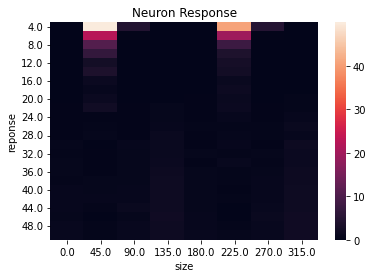

In [ ]:
vgg_model = tf.keras.applications.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

intermediate_activation = tf.keras.Model(inputs=vgg_model.input,
                                                  outputs=vgg_model.get_layer('block2_conv2').output)


def find_optimal_grating(d1, d2, d3):

  df = pd.DataFrame(columns=['Sf', 'Ori', 'Average_phase'])
  phase = []
  for i in range(4, 51, 2):
    for j in range(0, 316, 45):
      for k in range(0, 316, 45):
        inpt = np.expand_dims(np.asarray((makeGrating(11, i, j, k)/127.5)-1),0)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        n = activation_layer[0, d1, d2, d3]
        phase.append(n)
      phase_avg = sum(phase)/len(phase)
      df.loc[len(df.index)] = [i, j, phase_avg]
      phase = []

  heatmap_data = pd.pivot_table(df, values='Average_phase', index=['Sf'], columns='Ori')
  ax = sns.heatmap(heatmap_data)
  plt.xlabel("Orientation")
  plt.ylabel("Spacial Frequency")
  plt.title("Neuron Response")
  filtered =  df[df.Average_phase==df.Average_phase.max()]
  return filtered.iloc[0]['Sf'], filtered.iloc[0]['Ori']

def size_variation_response(freq, orient, d1, d2, d3):
  x = []
  y = []
  phase = []
  for i in range(1, 50, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, freq, orient, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, d1, d2, d3]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  plt.plot(x, y)
  plt.xlabel("size")
  plt.ylabel("reponse")
  plt.show()



sf1, ori1 = find_optimal_grating(56, 56, 10)


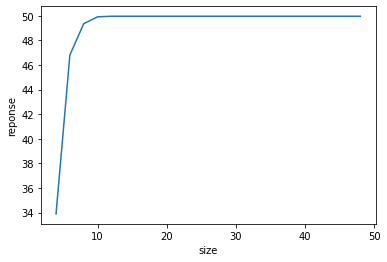

In [ ]:
def size_variation_response(freq, orient, d1, d2, d3):
  x = []
  y = []
  phase = []
  for i in range(4, 50, 2):
    for j in range(0, 316, 45):
      inpt = np.expand_dims(np.asarray((makeGrating(i, freq, orient, j)/127.5)-1),0)
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, d1, d2, d3]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i)
    y.append(phase_avg)
    phase = []

  plt.plot(x, y)
  plt.xlabel("size")
  plt.ylabel("reponse")
  plt.show()

size_variation_response(sf1, ori1, 56, 56, 10)

In [ ]:
# util functions
vgg_model = tf.keras.applications.VGG19(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

def generate_heatmap_data(ctr_lyr, neuron):
  df = pd.DataFrame(columns=['Spacial_Frequency', 'Orientation', 'Avg_Response_Over_Phases'])
  phase = []
  # size = 30 # set grating diameter
  for i in range(4, 51, 2): # spacial frequency
    for j in range(0, 166, 15): # orientation
      for k in range(0, 316, 45): # phase
        im = makeGrating(size, i, j, k, shift=shift)
        inpt = np.expand_dims(im,0)
        inpt = tf.keras.applications.vgg19.preprocess_input(inpt)
        activation_layer = intermediate_activation(inpt, training=False).numpy()
        n = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
        phase.append(n)
      phase_avg = sum(phase)/len(phase) # average of phase
      df.loc[len(df.index)] = [i, j, phase_avg]
      phase = []
  return df

def find_optimal_grating(df):
  filtered =  df[df.Avg_Response_Over_Phases==df.Avg_Response_Over_Phases.max()] # new dataframe with row where average response is highest
  return filtered.iloc[0]['Spacial_Frequency'], filtered.iloc[0]['Orientation']

def increase_grating_size(freq, orient, ctr_lyr, neuron, contrast=1.0, shift=0):
  x = []
  y = []
  phase = []
  for i in range(0, 50, 2): # size
    for j in range(0, 316, 45): # phase
      im = makeGrating(i, freq, orient, j, shift=shift)
      inpt = np.expand_dims(im,0)
      inpt = tf.keras.applications.vgg19.preprocess_input(inpt) # normalize vgg inputs
      activation_layer = intermediate_activation(inpt, training=False).numpy()
      n = activation_layer[0, ctr_lyr, ctr_lyr, neuron]
      phase.append(n)
    phase_avg = sum(phase)/len(phase)
    x.append(i) # list of grating size
    y.append(phase_avg) # list of average neuron reponse over phases
    phase = []

  return x, y

block2_conv2: 20


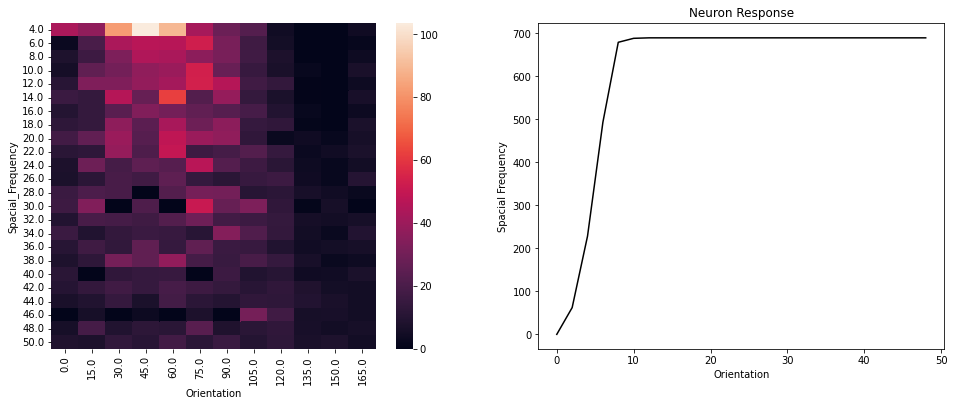

block3_conv1: 20


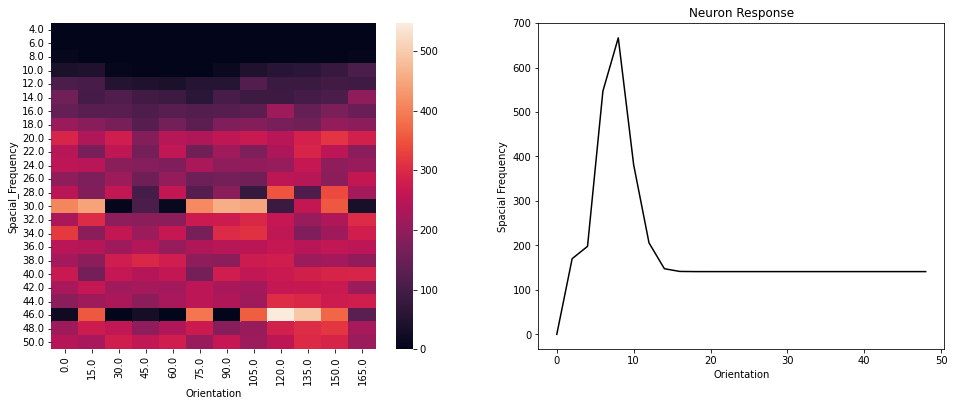

block2_conv2: 20


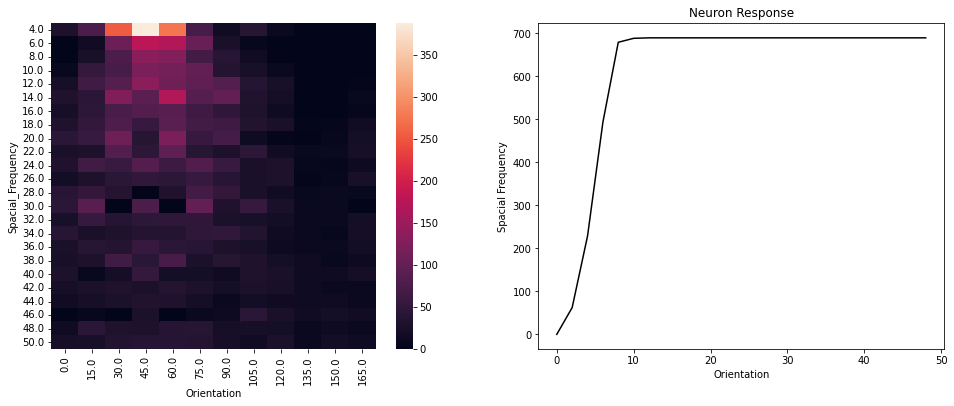

block3_conv1: 20


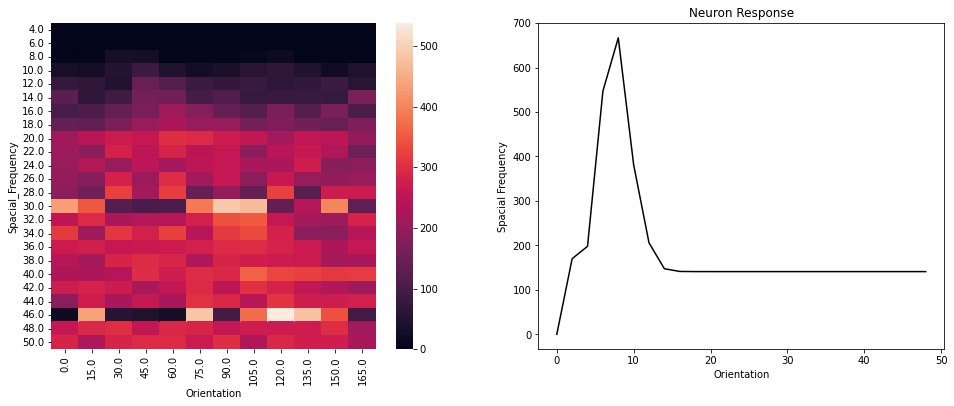

In [ ]:
for num in range(2):
  for layer in ['block2_conv2', 'block3_conv1']:
    intermediate_activation = tf.keras.Model(inputs=vgg_model.input,
                                                    outputs=vgg_model.get_layer(layer).output)
    ctr_lyr = int(vgg_model.get_layer(layer).output_shape[1]/2)
    shift = int((224/vgg_model.get_layer(name=layer).output_shape[1])/2)


    if num == 0:
      if layer == 'block2_conv2':
        size = int(15*0.5/2) 
      elif layer == 'block3_conv1':
        size = int(27*0.5/2) 
    elif num == 1:
      if layer == 'block2_conv2':
        size = int(15*0.7/2) 
      elif layer == 'block3_conv1':
        size = int(27*0.7/2) 

    neuron = 20
    print(layer+': '+str(neuron))
    # heatmap data
    hm_data = generate_heatmap_data(ctr_lyr, neuron) 
    # heatmap plot
    hm_pivot = pd.pivot_table(hm_data, values='Avg_Response_Over_Phases', index=['Spacial_Frequency'], columns='Orientation')
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))

    sns.heatmap(hm_pivot, ax=ax[0])
    plt.xlabel("Orientation")
    plt.ylabel("Spacial Frequency")
    plt.title("Neuron Response")

      # optimal stimulus
    sf, ori = find_optimal_grating(hm_data)
      
      # diamieter tuning curve data
    sizes, responses = increase_grating_size(sf, ori, ctr_lyr, neuron, shift=shift)

      # diamieter tuning curve plot
    plt.plot(sizes, responses, color='black')
    plt.show()

In [ ]:
intermediate_activation = tf.keras.Model(inputs=vgg_model.input,
                                                    outputs=vgg_model.get_layer('block3_conv1').output)
im = makeGrating(10, 4, 45, 45, shift=shift)
inpt = np.expand_dims(im,0)
inpt = tf.keras.applications.vgg19.preprocess_input(inpt)

activation_layer = intermediate_activation(inpt, training=False).numpy()
n = activation_layer[0, 28, 28, 20]

In [ ]:
# heat map, tuning curve, suppression index for block 3 conv 1 layer 

suppression = []
layer = 'block3_conv1'
intermediate_activation = tf.keras.Model(inputs=vgg_model.input,
                                                  outputs=vgg_model.get_layer(layer).output)
ctr_lyr = int(vgg_model.get_layer(layer).output_shape[1]/2)
shift = int((224/vgg_model.get_layer(name=layer).output_shape[1])/2)

if layer == 'block2_conv2': # saturation of diameter tuning curve
  size = int(15*0.7/2) # changed from 0.7 to 0.5
elif layer == 'block3_conv1': # first layer that shows suppression
  size = int(27*0.7/2)
elif layer == 'block3_conv2':
  size = int(35*0.7/2)
elif layer == 'block3_conv3':
  size = int(43*0.7/2)

saved = []
for i in range(4, 51, 2): # spacial frequency
  for j in range(0, 166, 15): # orientation
    for k in range(0, 316, 45): # phase
      im = makeGrating(size, i, j, k, shift=shift)
      inpt = np.expand_dims(im,0)
      inpt = tf.keras.applications.vgg19.preprocess_input(inpt) # normalize vgg inputs
      saved.append(inpt)

neurons = [11, 12, 13]
for neuron in range(len(neurons)): #model.get_layer(layer).output_shape[3]
  print(layer+': '+str(neuron))
      # heatmap data
  hm_data = generate_heatmap_data(ctr_lyr, neuron) # this function uses "saved"
  hm_data.to_csv(f'/content/drive/MyDrive/model/VGG/results_70radius/heatmap/data/{layer}/{neuron}_heatmap.csv')
      # heatmap plot
  hm_pivot = pd.pivot_table(hm_data, values='Avg_Response_Over_Phases', index=['Spacial_Frequency'], columns='Orientation')
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))

  sns.heatmap(hm_pivot, ax=ax[0])
  plt.xlabel("Orientation")
  plt.ylabel("Spacial Frequency")
  plt.title("Neuron Response")
  plt.savefig(f'/content/drive/MyDrive/model/VGG/results_70radius/heatmap/img/{layer}/{neuron}_heatmap.png')
      
      # optimal stimulus
  sf, ori = find_optimal_grating(hm_data)
  np.save(f"/content/drive/MyDrive/model/VGG/results_70radius/optimal_sti/{layer}/{neuron}_optsti.npy", np.asarray([sf, ori]))
      
      # diamieter tuning curve data
  sizes, responses = increase_grating_size(sf, ori, ctr_lyr, neuron, shift=shift)
  np.save(f"/content/drive/MyDrive/model/VGG/results_70radius/diameter_tuning/dia_tuning_data/{layer}/{neuron}_dia_tuning.npy", np.asarray([sizes, responses]))

      # suppression index
  max_index = np.argmax(responses)
  max_r = np.max(responses)
  suppress_r = np.min(responses[max_index:])
  suppress_idx =  1-suppress_r/max_r
  suppression.append(suppress_idx)

      # diamieter tuning curve plot
  ax[1].plot(sizes, responses, color='black')

      # low contrast
  sizes, responses = increase_grating_size(sf, ori, ctr_lyr, neuron, shift=shift, contrast=0.13)
  np.save(f"/content/drive/MyDrive/model/VGG/results_70radius/diameter_tuning/dia_tuning_data/{layer}/{neuron}_dia_tuning_lowcontrast.npy", np.asarray([sizes, responses]))
  ax[1].plot(sizes, responses, color='gray')

  plt.xlabel("Size")
  plt.ylabel("Reponse")
  plt.title("Neuron Response")
  plt.savefig(f"/content/drive/MyDrive/model/VGG/results_70radius/diameter_tuning/dia_tuning_plot/{layer}/{neuron}_dia_tuning.png", dpi=600)
  plt.clf()

# save suppresion index for layer
np.save(f"/content/drive/MyDrive/model/VGG/results_70radius/suppression_idx/{layer}_suppression.npy", np.asarray([np.arange(len(neurons)), suppression]))